# TO DO:

I) Belleza del código.

    1) Convertir listas en numpy array.
    
II) Preprocesamiento, ML, yerbas...

    1) (http://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers)Probar "robust_scale and RobustScaler" en vez de normalization de los datos
    2) Probar Grid_SearchCV en vez del "for"
    
III) Probar más hiperparametros

In [1]:
# Python 2 
from __future__ import division

# Dataframe
import pandas as pd
import numpy as np

# Time measurement
import datetime

# Visu
import matplotlib.pyplot as plt

# The Hashing Trick
from sklearn.feature_extraction import FeatureHasher

# Dimension Reduction
from sklearn.decomposition import TruncatedSVD

# ML
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor

# Scoring
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Training Data Load

In [2]:
stations = pd.read_csv('data/station.csv')

trips = pd.read_csv('data/trip_train.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True, low_memory=False)

weather = pd.read_csv('data/weather.csv', parse_dates=['date'], infer_datetime_format=True)

In [3]:
trips.columns

Index([u'id', u'duration', u'start_date', u'start_station_name',
       u'start_station_id', u'end_date', u'end_station_name',
       u'end_station_id', u'bike_id', u'subscription_type', u'zip_code'],
      dtype='object')

In [4]:
trips['date'] = pd.to_datetime(trips.start_date.dt.date)

In [5]:
original_number_of_trips = trips['duration'].shape[0]

trip_length = 60*60*12     # seconds in 12 hours
trips_larger_than_12_hour = trips[trips['duration'] > trip_length]['duration'].sum()
trips_shorter_than_12_hour = trips[trips['duration'] < trip_length]['duration'].sum()
ratio = trips_larger_than_12_hour/trips_shorter_than_12_hour
print (trips_larger_than_12_hour,"/",trips_shorter_than_12_hour,'=',ratio)

(118116828, '/', 494218194, '=', 0.23899732837435766)


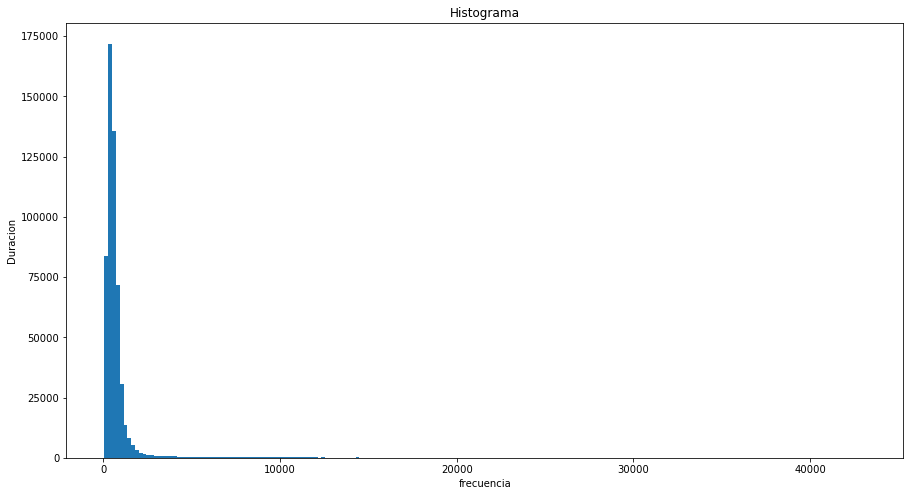

In [44]:
plt.figure(figsize=(15,8))
plt.title("Histograma de duracion de viajes")
plt.xlabel('frecuencia')
plt.ylabel('Duracion')
plt.hist(x=trips[trips['duration'] < trip_length]['duration'],bins=200)
plt.show()

In [7]:
trips = trips[trips['duration'] < trip_length]
print ("Total de viajes luego de remover outliers: " + str(trips.shape[0]))

Total de viajes luego de remover outliers: 548986


In [8]:
d = {'city': ['San Jose','Redwood City','Mountain View', 'Palo Alto', 'San Francisco'],\
         'zip_code':[95113,94063,94041,94301,94107]}
city_zip_codes = pd.DataFrame(data = d)

In [9]:
stations = pd.merge(stations, city_zip_codes, on='city', how='left')

In [10]:
# se agrega el zip_code de la ciudad de la start station a cada viaje
stations_to_join = stations.loc[:,['id','zip_code']]
stations_to_join.columns = ['start_station_id','city_zip_code']

trips = pd.merge(trips, stations_to_join, on='start_station_id', how='left')

In [11]:
weather.rename(columns={'zip_code':'city_zip_code'}, inplace=True)

In [12]:
data = pd.merge(trips, weather, on=['date','city_zip_code'], how='inner')

In [13]:
data.columns

Index([u'id', u'duration', u'start_date', u'start_station_name',
       u'start_station_id', u'end_date', u'end_station_name',
       u'end_station_id', u'bike_id', u'subscription_type', u'zip_code',
       u'date', u'city_zip_code', u'max_temperature_f', u'mean_temperature_f',
       u'min_temperature_f', u'max_dew_point_f', u'mean_dew_point_f',
       u'min_dew_point_f', u'max_humidity', u'mean_humidity', u'min_humidity',
       u'max_sea_level_pressure_inches', u'mean_sea_level_pressure_inches',
       u'min_sea_level_pressure_inches', u'max_visibility_miles',
       u'mean_visibility_miles', u'min_visibility_miles',
       u'max_wind_Speed_mph', u'mean_wind_speed_mph', u'max_gust_speed_mph',
       u'precipitation_inches', u'cloud_cover', u'events',
       u'wind_dir_degrees'],
      dtype='object')

In [14]:
# transformar cada date en segundos desde 29/04/1994
data.start_date = data.start_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))

data.end_date = data.end_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))

In [15]:
data.precipitation_inches = pd.to_numeric(data.precipitation_inches, errors='coerse')
data.precipitation_inches.fillna(0,inplace=True)

In [16]:
data.drop(labels=['id','start_station_name','end_station_name','date','zip_code','bike_id'], axis=1, inplace=True)
data.columns

Index([u'duration', u'start_date', u'start_station_id', u'end_date',
       u'end_station_id', u'subscription_type', u'city_zip_code',
       u'max_temperature_f', u'mean_temperature_f', u'min_temperature_f',
       u'max_dew_point_f', u'mean_dew_point_f', u'min_dew_point_f',
       u'max_humidity', u'mean_humidity', u'min_humidity',
       u'max_sea_level_pressure_inches', u'mean_sea_level_pressure_inches',
       u'min_sea_level_pressure_inches', u'max_visibility_miles',
       u'mean_visibility_miles', u'min_visibility_miles',
       u'max_wind_Speed_mph', u'mean_wind_speed_mph', u'max_gust_speed_mph',
       u'precipitation_inches', u'cloud_cover', u'events',
       u'wind_dir_degrees'],
      dtype='object')

In [17]:
trip_test = pd.read_csv('data/trip_test.csv')
trip_test.columns

Index([u'id', u'start_date', u'start_station_name', u'start_station_id',
       u'end_date', u'end_station_name', u'end_station_id', u'bike_id',
       u'subscription_type', u'zip_code'],
      dtype='object')

# The Hashing Trick

In [18]:
temp = []
column_labels = ['start_station_id','end_station_id','subscription_type','city_zip_code','events']

for row in data.loc[:,column_labels].iterrows():
    index, value = row
    for i in range(len(value)):
        value[i] = str(value[i])
    temp.append(value.tolist())

In [19]:
h = FeatureHasher(n_features=10, input_type='string')
f = h.transform(raw_X=temp)

In [20]:
print("Porcentaje de dispersidad: " + str((f.nnz/(f.shape[0] * f.shape[1]))*100) + " %")

Porcentaje de dispersidad: 41.1938920118 %


In [21]:
data = pd.concat([data,pd.DataFrame(f.todense())],axis=1)
data.drop(labels=column_labels,axis=1,inplace=True)

In [22]:
# Verificamos que sean todos numericos
data.dtypes

duration                            int64
start_date                          int64
end_date                            int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches              float64
cloud_cover                       float64
wind_dir_degrees                  

In [23]:
data = data.dropna(how='any').reset_index(drop=True)

In [24]:
print ("Cantidad de muestras en train set: "+str(data.shape[0]))

Cantidad de muestras en train set: 532389


In [25]:
# Separamos y de x
target_values = data['duration']
data.drop(labels='duration', axis=1, inplace=True)

# Data normalization

In [26]:
data = (data - data.mean()) / (data.max() - data.min())

# Dimension Reduction

## SVD

In [27]:
u,s,v = np.linalg.svd(data.as_matrix(),full_matrices=0)

## Energía de la matriz

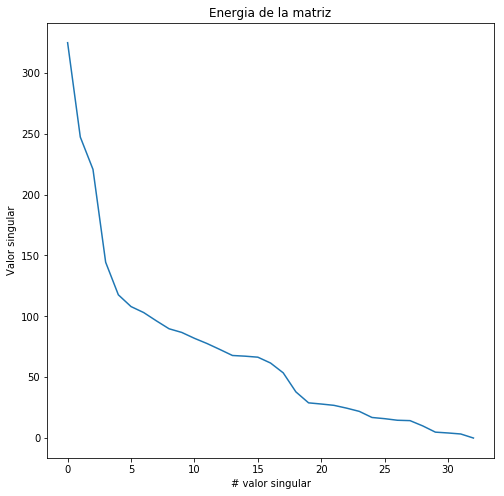

In [46]:
plt.figure(figsize=(8,8))
plt.xlabel("# valor singular")
plt.ylabel('Valor singular')
plt.title("Energia de la matriz")
plt.plot(s)
plt.show()

Vemos un codo en x = 5

# Aproximation error

In [29]:
dim = 5
closeness = np.isclose(np.dot(np.dot(u[:,0:dim],np.diag(s)[0:dim,0:dim]),v[0:dim,:]),data,atol=0.1,rtol=0.1)
print (str((closeness.sum()/(closeness.shape[0]*closeness.shape[1])*100).round(2)) + " %")

90.69 %


# Truncated SVD

[...it can work with scipy.sparse matrices efficiently.](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [30]:
svd = TruncatedSVD(n_components=7, n_iter=7, random_state=42)
truncated_svd_aprox = svd.fit_transform(data)

# KNN 

In [31]:
reduced_data = truncated_svd_aprox

In [32]:
k_neighbors = np.array(range(10,1001,10))
metrics = ['euclidean', 'manhattan']
KNN_cv_scores = np.zeros(shape=(len(k_neighbors),len(metrics)))

for i,k in enumerate(k_neighbors):
    for j,metric in enumerate(metrics):
        
        knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric=metric, weights = 'distance',n_jobs=-1)
        scores = cross_val_score(knn, reduced_data, target_values, cv=10, scoring='neg_mean_squared_error')
        KNN_cv_scores[i][j] = scores.mean()

KeyboardInterrupt: 

In [33]:
KNN_cv_scores.round(2)

array([[-6134361.15, -6079000.66],
       [-5351858.19, -5360234.74],
       [-5096953.65, -5095805.17],
       [-4982807.73, -4969350.65],
       [-4907901.23, -4890164.21],
       [-4852908.1 , -4834866.28],
       [-4817307.43, -4797754.1 ],
       [-4790579.12, -4769114.32],
       [-4767948.63, -4745718.41],
       [-4751342.63, -4727356.28],
       [-4739709.84, -4711076.88],
       [-4726830.06, -4696665.8 ],
       [-4715715.18, -4687716.97],
       [-4706229.36, -4678451.76],
       [-4697689.8 , -4670741.08],
       [-4691308.05, -4665357.65],
       [-4684562.35, -4659308.18],
       [-4677509.1 , -4653394.41],
       [-4672237.78, -4648805.1 ],
       [-4667755.94, -4644264.32],
       [-4662907.25, -4640719.22],
       [-4658321.77, -4637249.78],
       [-4654066.51, -4632933.27],
       [-4650221.86, -4629486.34],
       [-4646538.86, -4627016.1 ],
       [-4642953.85, -4623886.01],
       [-4639515.33, -4621242.79],
       [-4636040.7 , -4618465.53],
       [-4632803.81,

In [40]:
KNN_cv_scores = np.array([[-6134361.15, -6079000.66],
					  [-5351858.19, -5360234.74],
					  [-5096953.65, -5095805.17],
					  [-4982807.73, -4969350.65],
					  [-4907901.23, -4890164.21],
					  [-4852908.1 , -4834866.28],
					  [-4817307.43, -4797754.1 ],
					  [-4790579.12, -4769114.32],
					  [-4767948.63, -4745718.41],
					  [-4751342.63, -4727356.28],
					  [-4739709.84, -4711076.88],
					  [-4726830.06, -4696665.8 ],
					  [-4715715.18, -4687716.97],
					  [-4706229.36, -4678451.76],
					  [-4697689.8 , -4670741.08],
					  [-4691308.05, -4665357.65],
					  [-4684562.35, -4659308.18],
					  [-4677509.1 , -4653394.41],
					  [-4672237.78, -4648805.1 ],
					  [-4667755.94, -4644264.32],
					  [-4662907.25, -4640719.22],
					  [-4658321.77, -4637249.78],
					  [-4654066.51, -4632933.27],
					  [-4650221.86, -4629486.34],
					  [-4646538.86, -4627016.1 ],
					  [-4642953.85, -4623886.01],
					  [-4639515.33, -4621242.79],
					  [-4636040.7 , -4618465.53],
					  [-4632803.81, -4615791.91],
					  [-4629935.04, -4613384.22],
					  [-4626602.03, -4611437.69],
					  [-4623721.83, -4608700.33],
					  [-4620566.86, -4606371.71],
					  [-4617386.36, -4604447.74],
					  [-4614419.37, -4603139.35],
					  [-4611734.2 , -4601562.83],
					  [-4609026.51, -4600178.79],
					  [-4607345.74, -4598160.78],
					  [-4605116.73, -4596688.19],
					  [-4603376.65, -4595194.93],
					  [-4601587.53, -4593121.06],
					  [-4600001.43, -4591552.04],
					  [-4598164.87, -4589910.62],
					  [-4596167.67, -4588453.26],
					  [-4594644.11, -4587628.87],
					  [-4593058.82, -4586432.97],
					  [-4591440.79, -4585359.34],
					  [-4590444.87, -4584486.15],
					  [-4588931.37, -4583458.19],
					  [-4587514.33, -4582651.52],
					  [-4585932.58, -4581528.13],
					  [-4584639.75, -4580836.93],
					  [-4583219.7 , -4579824.95],
					  [-4582349.66, -4579051.76],
					  [-4581703.28, -4578455.81],
					  [-4580664.6 , -4577890.98],
					  [-4579859.66, -4577140.71],
					  [-4578952.79, -4576545.1 ],
					  [-4578190.6 , -4576011.88],
					  [-4577508.68, -4575313.46],
					  [-4576812.1 , -4574810.81],
					  [-4576117.07, -4574246.79],
					  [-4575456.42, -4573528.77],
					  [-4575079.77, -4572995.22],
					  [-4574456.42, -4572555.19],
					  [-4573733.31, -4572173.41],
					  [-4572835.86, -4571679.54],
					  [-4571944.24, -4571347.05],
					  [-4571243.67, -4570827.76],
					  [-4570673.91, -4570314.32],
					  [-4570125.56, -4569726.02],
					  [-4569402.35, -4569275.26],
					  [-4568853.66, -4568817.24],
					  [-4568299.57, -4568358.15],
					  [-4567749.82, -4567980.21],
					  [-4567306.32, -4567479.81],
					  [-4566973.99, -4567107.05],
					  [-4566390.23, -4566979.09],
					  [-4566209.39, -4566688.21],
					  [-4565677.62, -4565677.62]])

KNN_cv_scores.max()

-4565677.6200000001

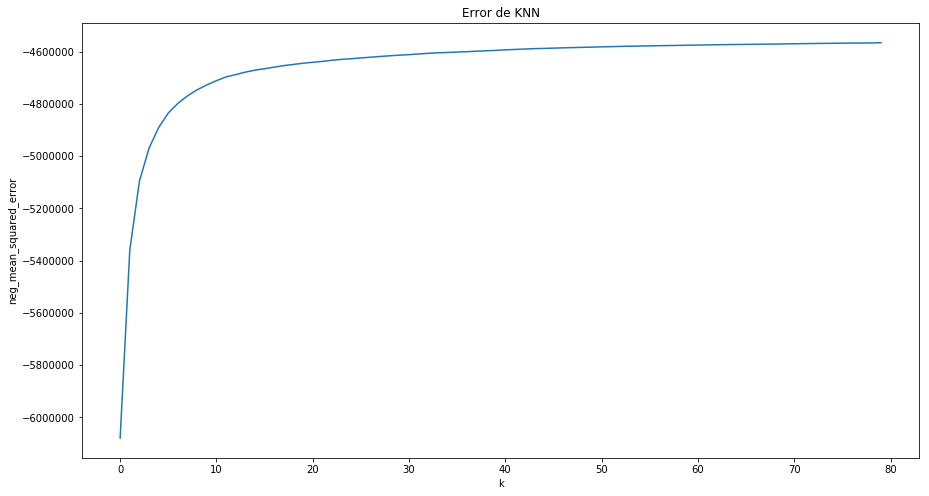

In [77]:
plt.figure(figsize=(15,8))
plt.plot(KNN_cv_scores[:,1])
plt.title("Error de KNN")
plt.xlabel("k")
plt.ylabel("neg_mean_squared_error")
plt.show()

In [76]:
# print (np.array(KNN_cv_scores).round(2)

# Estos prints están mal

print ("Best MSE: " + str(np.array(KNN_cv_scores).round(2).max()))
print ("Index of best MSE: " + str (np.array(KNN_cv_scores).round(2).argmax(axis=0)))
print ("Best k: " + str(k_neighbors[KNN_cv_scores.round(2).argmax(axis=1)[0]]) )
print ("Best metric: " + str(metrics[KNN_cv_scores.round(2).argmax(axis=1)[1]] ) )

Best MSE: -4565677.62
Index of best MSE: [79 79]
Best k: 20
Best metric: euclidean


# Decision Tree Regressor

In [ ]:
possible_depth = np.array(range(10,1001,10))

In [ ]:
cv_scores = []

for current_depth in possible_depth:
    
    regr_1 = DecisionTreeRegressor(max_depth=current_depth)
    scores = cross_val_score(regr_1, data, target_values, cv=10, scoring='neg_mean_squared_error')
    DTR_cv_scores.append(scores.mean())

In [ ]:
print ("Best MSE: " + str(np.array(cv_scores).round(2).max()))
print ("Index of best MSE: " + str (np.array(cv_scores).round(2).argmax()))
print ("Best depth: " + str(possible_depth[np.array(cv_scores).round(2).argmax()]))

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(x=range(len(y_1)),y=y_1)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.ylim(0,531240)
plt.scatter(x=range(len(Y_test)),y=Y_test)

# Random Forest Regressor

In [ ]:
regr_1 = RandomForestRegressor(n_estimators=5, criterion='mse')
scores = cross_val_score(regr_1, reduced_data, target_values, cv=10, scoring='neg_mean_squared_error')

In [ ]:
scores.mean()